In [22]:
source("/root/workspace/code/sc-transformer/preprocess/utils.R")
setwd("/root/workspace/code/sc-transformer/")
library(RColorBrewer)
library(patchwork)

parser <- ArgumentParser()
parser$add_argument("--reference", type = "character", default = "atlas_no_dogma")
parser$add_argument("--experiment", type = "character", default = "e0")
parser$add_argument("--model", type = "character", default = "default")
parser$add_argument("--init_model", type = "character", default = "sp_00003799")
parser$add_argument("--method", type = "character", default = "midas_embed")
o <- parser$parse_known_args()[[1]]

tasks <- c("full", "paired_full", "paired_abc", "paired_ab", "paired_ac", "paired_bc", "single_full", "single",
           "paired_a", "paired_b", "paired_c", "single_atac", "single_rna", "single_adt")
tasks <- paste0("dogma_", tasks, "_continual")

task_names <- c("full", "paired+full", "paired-abc", "paired-ab", "paired-ac", "paired-bc", "diagonal+full", "diagonal",
           "paired-a", "paired-b", "paired-c", "atac", "rna", "adt")
task_names <- paste0("dogma-", task_names)
task_name_map <- list()
for (i in seq_along(tasks)) {
    task_name_map[[tasks[i]]] <- task_names[i]
}

l <- 7.5  # figure size
L <- 10   # figure size
m <- 0.5  # legend margin

In [23]:
# Set colors
cell_label_unique <- vector()
for (task in tasks) {
    label_dir <- pj("result", "comparison", task, o$method, o$experiment, o$init_model)
    cell_label <- gsub(" cells", "", read.csv(pj(label_dir, "label_transferred.csv"), header = F)[, 1])
    cell_label_unique <- c(cell_label_unique, unique(cell_label))
}
labels <- str_sort(unique(cell_label_unique))

pal <- col_13
label_to_color <- list()
for (i in seq_along(labels)) {
    label_to_color[[labels[i]]] <- pal[i]
}
cols <- c("#E5E5E5")
for (label in labels) {
    cols <- c(cols, label_to_color[[label]])
}

order <- c(rev(labels), "Unselected")

In [24]:
## For CL tasks

library(foreach)
library(doParallel)
myCluster <- makeCluster(length(tasks), type = "FORK") # type of cluster
registerDoParallel(myCluster)

plts <- foreach(task = tasks) %dopar% {
    # Load configs
    config <- parseTOML("configs/data.toml")[[gsub("_continual", "", task)]]
    config_ref <- parseTOML("configs/data.toml")[[o$reference]]
    query_subset_num <- length(config[["s_joint"]])
    config[["raw_data_dirs"]] <- c(config[["raw_data_dirs"]], config_ref[["raw_data_dirs"]])
    config[["raw_data_frags"]] <- c(config[["raw_data_frags"]], config_ref[["raw_data_frags"]])
    config[["combs"]] <- c(config[["combs"]], config_ref[["combs"]])
    config[["comb_ratios"]] <- c(config[["comb_ratios"]], config_ref[["comb_ratios"]])
    config[["s_joint"]] <- c(config[["s_joint"]], sapply(X = config_ref[["s_joint"]], FUN = function(x) {x + query_subset_num}))

    subset_names <- basename(config$raw_data_dirs)
    subset_ids <- sapply(seq_along(subset_names) - 1, toString)
    input_dirs <- pj("result", task, o$experiment, o$model, "predict", o$init_model, paste0("subset_", subset_ids))
    pp_dir <- pj("data", "processed", "atlas")
    output_dir <- pj("result", "comparison", task, o$method, o$experiment, o$init_model)
    mkdir(output_dir, remove_old = F)

    K <- parseTOML("configs/model.toml")[["default"]]$dim_c


    # # Load preprossed data
    # z_list <- list()
    # cell_name_list <- list()
    # subset_name_list <- list()
    # S <- length(subset_names)
    # for (i in seq_along(subset_names)) {
    #     subset_name <- subset_names[i]
    #     z_dir    <- pj(input_dirs[i], "z", "joint")
    #     fnames <- dir(path = z_dir, pattern = ".csv$")
    #     fnames <- str_sort(fnames, decreasing = F)

    #     z_subset_list <- list()
    #     N <- length(fnames)
    #     for (n in seq_along(fnames)) {
    #         message(paste0("Loading Subset ", i, "/", S, ", File ", n, "/", N))
    #         z_subset_list[[n]] <- read.csv(file.path(z_dir, fnames[n]), header = F)
    #     }
    #     z_list[[subset_name]] <- bind_rows(z_subset_list)
        
    #     cell_name_list[[subset_name]] <- read.csv(pj(pp_dir, paste0("subset_", subset_ids[i]),
    #         "cell_names.csv"), header = T)[, 2]
        
    #     subset_name_list[[subset_name]] <- rep(subset_name, length(cell_name_list[[subset_name]]))
    # }


    # # Create seurat object
    # rna <- t(data.matrix(bind_rows(z_list))) * 0  # pseudo rna counts
    # colnames(rna) <- do.call("c", unname(cell_name_list))
    # rownames(rna) <- paste0("rna-", seq_len(nrow(rna)))
    # obj <- CreateSeuratObject(counts = rna, assay = "rna")

    # z <- data.matrix(bind_rows(z_list))
    # c <- z[, 1:K]
    # colnames(c) <- paste0("c_", seq_len(ncol(c)))
    # rownames(c) <- colnames(obj)
    # obj[["c"]] <- CreateDimReducObject(embeddings = c, key = "c_", assay = "rna")

    # obj@meta.data$batch <- factor(x = do.call("c", unname(subset_name_list)), levels = subset_names)
    # table(obj@meta.data$batch)[unique(obj@meta.data$batch)]

    # obj


    # # Generate UMAP for visualization
    # obj <- RunUMAP(obj, reduction = 'c', dims = 1:K, reduction.name = 'c.umap')
    # SaveH5Seurat(obj, pj(output_dir, "obj.h5seurat"), overwrite = TRUE)
    obj <- LoadH5Seurat(pj(output_dir, "obj.h5seurat"), reductions = "c.umap")


    # set groups for highlighting
    obj@meta.data$highlight <- "Unselected"
    select_mask <- obj@meta.data$batch %in% subset_names[1:query_subset_num]
    labels_selected <- gsub(" cells", "", read.csv(pj(output_dir, "label_transferred.csv"), header = F)[, 1])
    obj@meta.data$highlight[select_mask] <- labels_selected

    # plot
    p <- DimPlot(obj, reduction = "c.umap", group.by = "highlight", repel = T,
            label.size = 4, pt.size = 0.1, shuffle = F, cols = cols, order = order, raster = T, raster.dpi = c(250, 250))

    p <- p + ggtitle(task_name_map[[task]]) + theme(plot.title = element_text(face = "plain", size = 30))
    p <- p + NoLegend() + NoAxes() +
        theme(panel.border = element_rect(color = "black", linewidth = 1),
        axis.ticks.length = unit(0, "pt"), plot.margin = margin(0, 0, 20, 0)) +
        scale_colour_manual(values = cols, drop = FALSE) +
        labs(colour = "Cell type")

    p
}

stopCluster(myCluster)

In [25]:
# For atlas

# Load configs
task <- "atlas"
config <- parseTOML("configs/data.toml")[[task]]
query_subset_num <- 4

subset_names <- basename(config$raw_data_dirs)
subset_ids <- sapply(seq_along(subset_names) - 1, toString)
input_dirs <- pj("result", task, o$experiment, o$model, "predict", "sp_latest", paste0("subset_", subset_ids))
pp_dir <- pj("data", "processed", "atlas")
output_dir <- pj("result", "comparison", task, o$method, o$experiment, "sp_latest")
mkdir(output_dir, remove_old = F)

K <- parseTOML("configs/model.toml")[["default"]]$dim_c


# # Load preprossed data
# z_list <- list()
# cell_name_list <- list()
# subset_name_list <- list()
# S <- length(subset_names)
# for (i in seq_along(subset_names)) {
#     subset_name <- subset_names[i]
#     z_dir    <- pj(input_dirs[i], "z", "joint")
#     fnames <- dir(path = z_dir, pattern = ".csv$")
#     fnames <- str_sort(fnames, decreasing = F)

#     z_subset_list <- list()
#     N <- length(fnames)
#     for (n in seq_along(fnames)) {
#         message(paste0("Loading Subset ", i, "/", S, ", File ", n, "/", N))
#         z_subset_list[[n]] <- read.csv(file.path(z_dir, fnames[n]), header = F)
#     }
#     z_list[[subset_name]] <- bind_rows(z_subset_list)
    
#     cell_name_list[[subset_name]] <- read.csv(pj(pp_dir, paste0("subset_", subset_ids[i]),
#         "cell_names.csv"), header = T)[, 2]
    
#     subset_name_list[[subset_name]] <- rep(subset_name, length(cell_name_list[[subset_name]]))
# }


# # Create seurat object
# rna <- t(data.matrix(bind_rows(z_list))) * 0  # pseudo rna counts
# colnames(rna) <- do.call("c", unname(cell_name_list))
# rownames(rna) <- paste0("rna-", seq_len(nrow(rna)))
# obj <- CreateSeuratObject(counts = rna, assay = "rna")

# z <- data.matrix(bind_rows(z_list))
# c <- z[, 1:K]
# colnames(c) <- paste0("c_", seq_len(ncol(c)))
# rownames(c) <- colnames(obj)
# obj[["c"]] <- CreateDimReducObject(embeddings = c, key = "c_", assay = "rna")

# obj@meta.data$batch <- factor(x = do.call("c", unname(subset_name_list)), levels = subset_names)
# table(obj@meta.data$batch)[unique(obj@meta.data$batch)]

# obj


# # Generate UMAP for visualization
# obj <- RunUMAP(obj, reduction = 'c', dims = 1:K, reduction.name = 'c.umap')
# SaveH5Seurat(obj, pj(output_dir, "obj.h5seurat"), overwrite = TRUE)
obj <- LoadH5Seurat(pj(output_dir, "obj.h5seurat"), reductions = "c.umap")


# set groups for highlighting
obj@meta.data$highlight <- "Unselected"
select_mask <- obj@meta.data$batch %in% subset_names[1:query_subset_num]
labels_selected <- gsub(" cells", "", read.csv(pj("result", "downstream", "labels", "labels2.atlas.csv"))[1:sum(select_mask), 2])
obj@meta.data$highlight[select_mask] <- labels_selected

# plot
p <- DimPlot(obj, reduction = "c.umap", group.by = "highlight", repel = T,
        label.size = 4, pt.size = 0.1, shuffle = F, cols = cols, order = order, raster = T, raster.dpi = c(250, 250))

p <- p + ggtitle("dogma-full (atlas)") + theme(plot.title = element_text(face = "plain", size = 30))
p <- p + NoLegend() + NoAxes() +
    theme(panel.border = element_rect(color = "black", linewidth = 1),
    axis.ticks.length = unit(0, "pt"), plot.margin = margin(0, 0, 20, 20)) +
    scale_colour_manual(values = cols, drop = FALSE) +
    labs(colour = "Cell type")

plts <- append(plts, list(p), 7)

Validating h5Seurat file

Initializing rna with data

Adding counts for rna

Adding miscellaneous information for rna

Adding reduction c.umap

Adding cell embeddings for c.umap

Adding miscellaneous information for c.umap

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



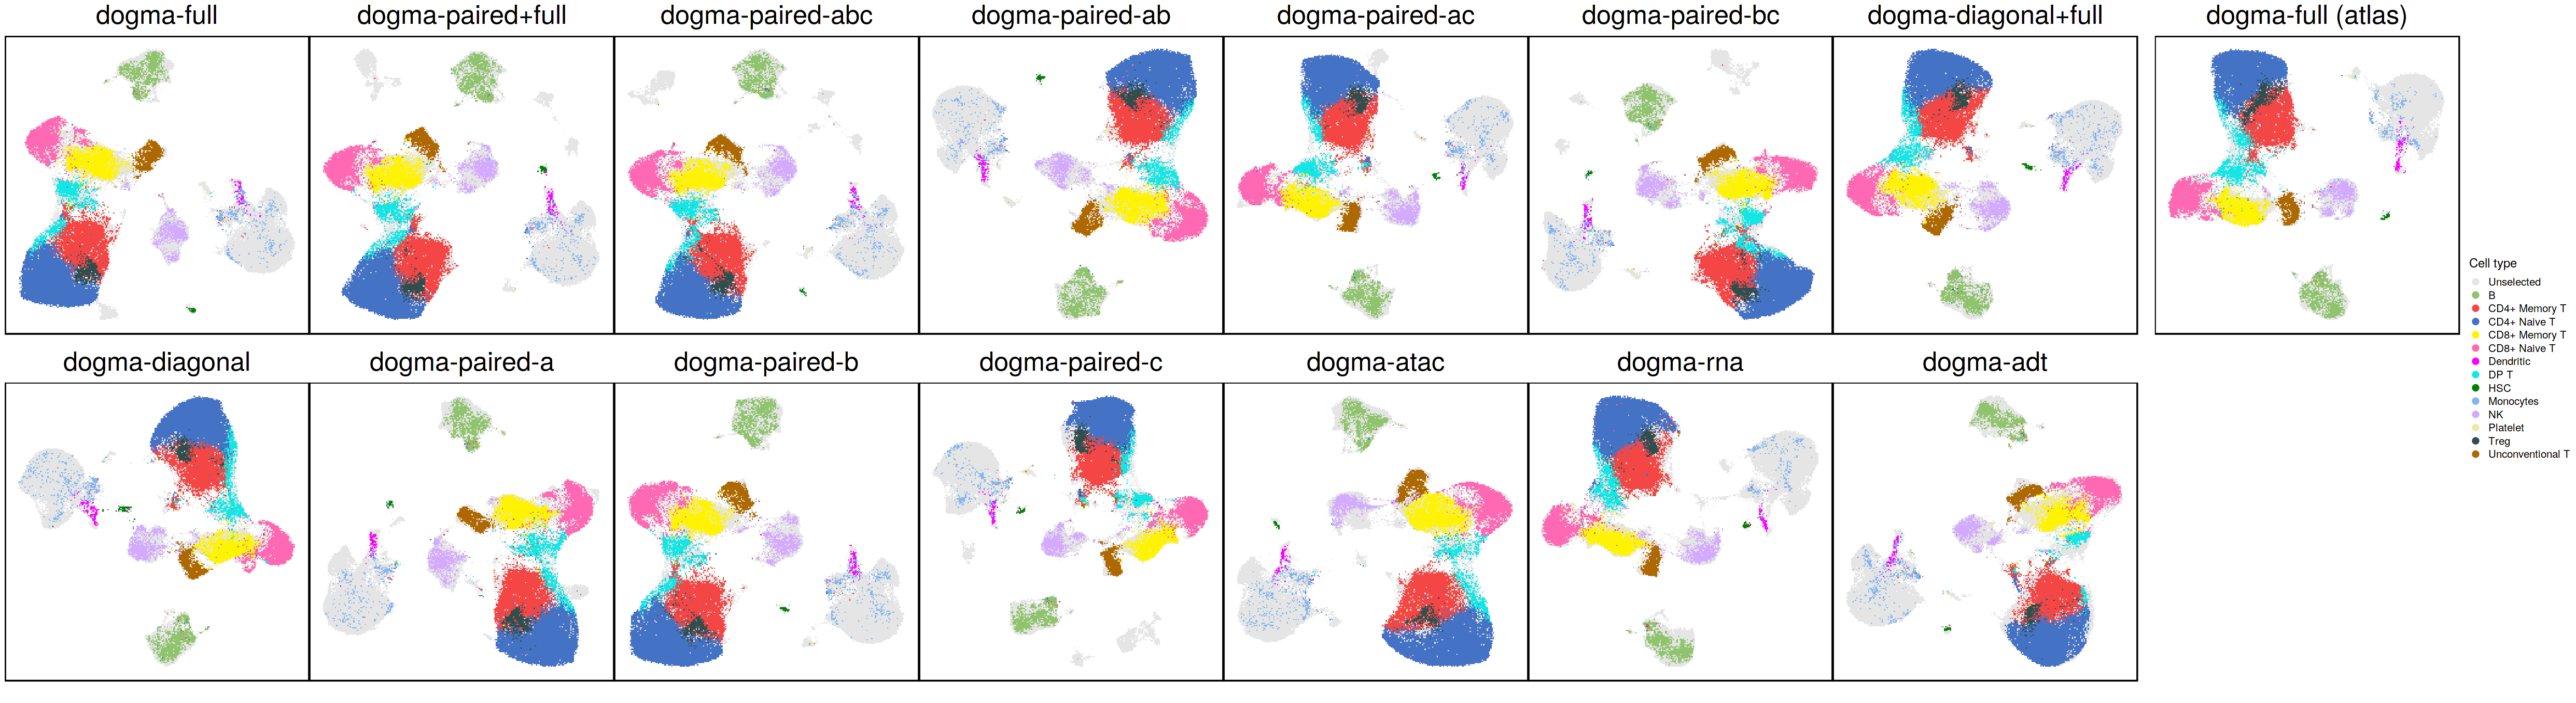

In [26]:
plt <- NULL
for (p in plts) {
    if (is.null(plt)) {
        plt <- p
    } else {
        plt <- plt + p
    }
}
plt <- plt + plot_layout(ncol = 8, guides = "collect") & theme(legend.position = "right")

w <- 5 * 8 + 1.4
h <- 5 * 2 + 1.3
plt_size(w, h)
plt

In [27]:
save_dir <- "paper/5"
mkdir(save_dir, remove_old = F)
ggsave(plot = plt, file = pj(save_dir, "5_label_transfer_umap.png"), width = w, height = h, limitsize = F)
ggsave(plot = plt, file = pj(save_dir, "5_label_transfer_umap.pdf"), width = w, height = h, limitsize = F)